In [2]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



In [3]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [4]:
class Sarsa:

    def __init__(self, col, row, learning_rate, gamma, epsilon, action_num = 4):
        self.Q_table = np.zeros([col*row, action_num])
        self.action_num = action_num
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_num)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def get_policy(self, state):
        Q_max = np.argmax(self.Q_table[state])
        a = [0 for i in range(self.action_num)]
        for i in range(self.action_num):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def sarsa_update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.learning_rate * td_error



In [73]:
col = 12
row = 4
env = CliffWalkingEnv(col, row)
np.random.seed(0)
epsilon = 0.1
learning_rate = 0.32
gamma = 0.9
agent = Sarsa(col, row, learning_rate, gamma, epsilon)

num_episodes = 500

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 2088.63it/s, episode=500, return=-18.300]


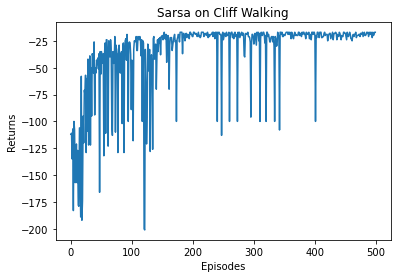

In [74]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)): 
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward
                agent.sarsa_update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()


In [ ]:
class n_step_Sarsa:
    def __init__(self, step_num, col, row, learning_rate, gamma, epsilon, action_num = 4):
        self.Q_table = np.zeros([col*row, action_num])
        self.action_num = action_num
        self.step_num = step_num
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon
        self.state_list = []
        self.action_list = []
        self.reward_list = []

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_num)
        else:
            action = np.argmax(self.Q_table[state])
        return action
    
    def get_policy(self, state):
        Q_max = np.argmax(self.Q_table[state])
        a = [0 for i in range(self.action_num)]
        for i in range(self.action_num):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def n_step_Sarsa_update(self, s0, a0, r, s1, a1):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        